# Don't Make a Fruit Salad

All you need to know about Image Classification Techniques, applied on a Fruit Classification Task

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

import os, random
from glob import glob

# About the data

* Total number of images: 90483.
* Training set size: 67692 images (one fruit or vegetable per image).
* Test set size: 22688 images (one fruit or vegetable per image).
* Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)
* Number of classes: 131 (fruits and vegetables).
* Image size: 100x100 pixels.

In [2]:
DIR_TRAIN = '../input/fruits/fruits-360_dataset/fruits-360/Training'
DIR_TEST = '../input/fruits/fruits-360_dataset/fruits-360/Test'

In [3]:
target_classes = os.listdir(DIR_TRAIN)
num_classes = len(target_classes)
print('Number of target classes:', num_classes)
print(list(enumerate(target_classes)))

Number of target classes: 131
[(0, 'Quince'), (1, 'Grapefruit White'), (2, 'Granadilla'), (3, 'Orange'), (4, 'Apple Red 3'), (5, 'Grape White 2'), (6, 'Corn Husk'), (7, 'Tamarillo'), (8, 'Banana Red'), (9, 'Nectarine Flat'), (10, 'Pepper Yellow'), (11, 'Nut Forest'), (12, 'Pear Monster'), (13, 'Fig'), (14, 'Tomato Heart'), (15, 'Onion Red Peeled'), (16, 'Lemon Meyer'), (17, 'Onion Red'), (18, 'Passion Fruit'), (19, 'Cucumber Ripe'), (20, 'Cactus fruit'), (21, 'Tomato not Ripened'), (22, 'Mango Red'), (23, 'Apple Pink Lady'), (24, 'Pomegranate'), (25, 'Plum'), (26, 'Pineapple'), (27, 'Tomato 1'), (28, 'Cherry 2'), (29, 'Apple Red 2'), (30, 'Avocado ripe'), (31, 'Dates'), (32, 'Maracuja'), (33, 'Papaya'), (34, 'Nut Pecan'), (35, 'Pear Stone'), (36, 'Cherry Wax Yellow'), (37, 'Eggplant'), (38, 'Apple Golden 2'), (39, 'Guava'), (40, 'Beetroot'), (41, 'Tomato Maroon'), (42, 'Potato Red'), (43, 'Apple Red Delicious'), (44, 'Cherry Wax Red'), (45, 'Kiwi'), (46, 'Cherry Wax Black'), (47, 'Lime

In [4]:
training_set_distribution = [len(os.listdir(os.path.join(DIR_TRAIN, DIR))) for DIR in os.listdir(DIR_TRAIN)]
testing_set_distribution = [len(os.listdir(os.path.join(DIR_TEST, DIR))) for DIR in os.listdir(DIR_TEST)]

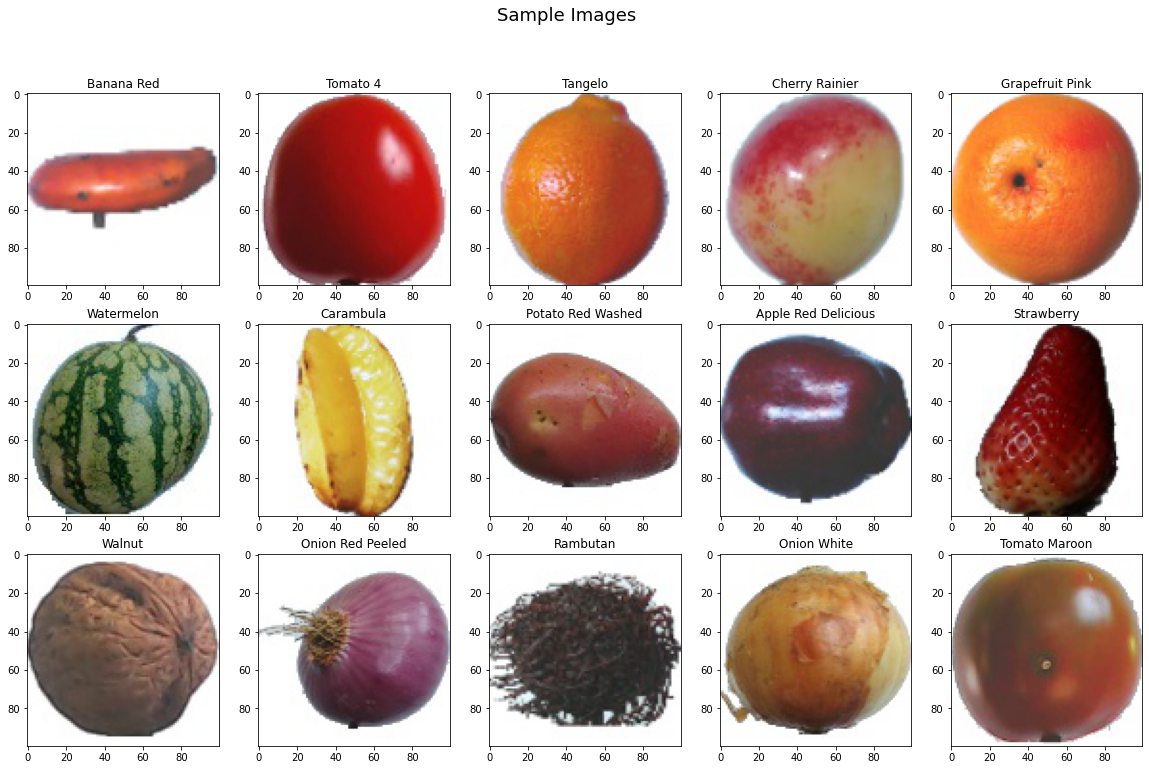

In [5]:
images = [
    (os.path.join(DIR_TRAIN, DIR, random.choice(
        os.listdir(os.path.join(DIR_TRAIN, DIR))
    )), DIR) for DIR in random.choices(os.listdir(DIR_TRAIN), k=15)
]

fig, ax = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('Sample Images', fontsize=18)

for i, img in enumerate(images):
    ax[i//5][i%5].imshow(plt.imread(img[0]))
    ax[i//5][i%5].set_title(img[1], fontsize=12)

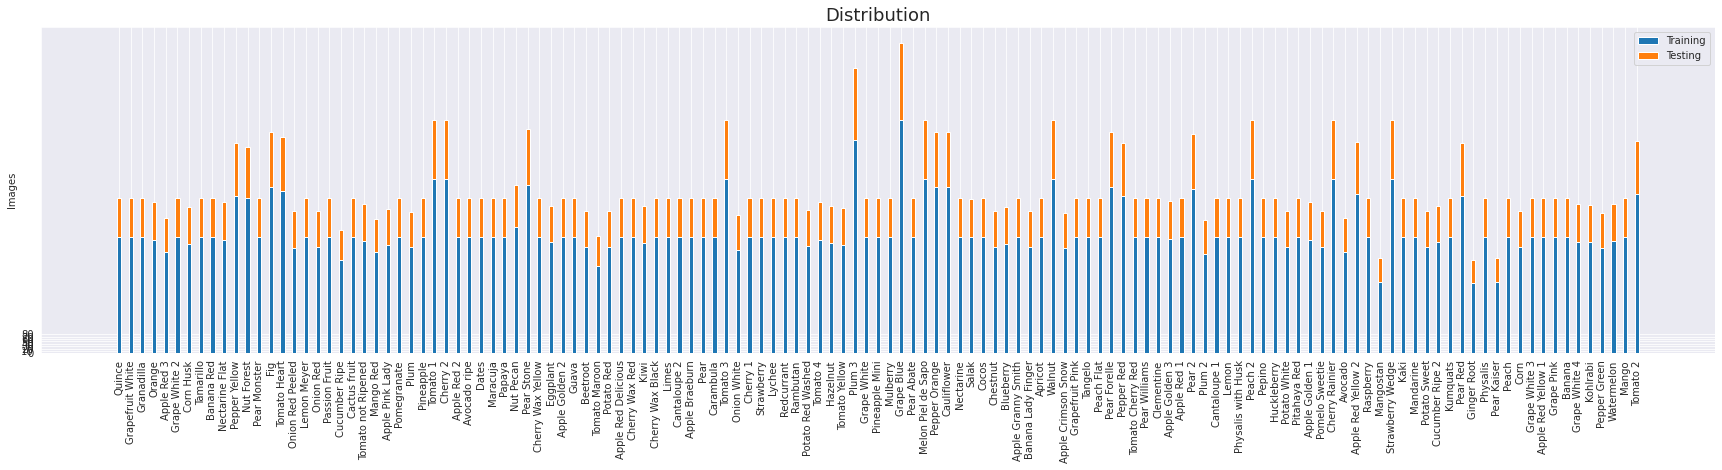

In [6]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(30, 6))

ind = np.arange(len(target_classes))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, training_set_distribution, width)
p2 = ax.bar(ind, testing_set_distribution, width, bottom=training_set_distribution)

plt.ylabel('Images')
plt.title('Distribution', fontsize=18)
plt.xticks(ind, target_classes, rotation=90)
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Training', 'Testing'));

# Loading and Augmenting Data

Deep networks need large amount of training data to achieve good performance. To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc

We will normailize the image pixel values to 0-1 range from 0-255 range
and will apply the following transformations randomly:
* flipping
* rotating

In [7]:
image_size = (100, 100, 3)

train_images = glob(f"{DIR_TRAIN}/*/*")
valid_images = glob(f"{DIR_TEST}/*/*")

BATCH_SIZE = 32

In [8]:
def load_images(imagePath):
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (100, 100))    
    label = tf.strings.split(imagePath, os.path.sep)[-2]
    
    oneHot = label == target_classes
    encodedLabel = tf.argmax(oneHot)

    return (image, encodedLabel)

def augment_using_ops(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.rot90(images)

    return (images, labels)

In [9]:
train_images = tf.data.Dataset.from_tensor_slices(train_images)
train_images = (train_images
    .shuffle(1024)
    .map(load_images, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)

valid_images = tf.data.Dataset.from_tensor_slices(valid_images)
valid_images = (valid_images
    .shuffle(1024)
    .map(load_images, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)

In [10]:
training_set = train_images.map(augment_using_ops, num_parallel_calls=-1)
validation_set = valid_images.map(augment_using_ops, num_parallel_calls=-1)

# Vanilla Convolutional Neural Network

A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers

**Convolutional Layers**

In mathematics, casually speaking, a mixture of two functions. In machine learning, a convolution mixes the convolutional filter and the input matrix in order to train weights.

* Element-wise multiplication of the convolutional filter and a slice of an input matrix. (The slice of the input matrix has the same rank and size as the convolutional filter.)
* Summation of all the values in the resulting product matrix.

![img](https://developers.google.com/machine-learning/glossary/images/ConvolutionalFilter33.svg)

One of the two actors in a convolutional operation. (The other actor is a slice of an input matrix.) A convolutional filter is a matrix having the same rank as the input matrix, but a smaller shape. For example, given a 28x28 input matrix, the filter could be any 2D matrix smaller than 28x28.

![img](https://developers.google.com/machine-learning/glossary/images/AnimatedConvolution.gif)

In photographic manipulation, all the cells in a convolutional filter are typically set to a constant pattern of ones and zeroes. Convolutional filters are typically seeded with random numbers and then the network trains the ideal values.

Following parameter characterize a Convolution Layer:
* Number of Filters
* Kernel Size: the height and width of the 2D convolution window
* Strides: the strides of the convolution along the height and width
* Padding: the amount of pixels added to an image when it is being processed by the kernel of a CNN
* Activation Function to be used

**Pooling Layer**

Reducing a matrix (or matrices) created by an earlier convolutional layer to a smaller matrix. Pooling usually involves taking either the maximum or average value across the pooled area. For example, suppose we have the following 3x3 matrix:

![img](https://developers.google.com/machine-learning/glossary/images/PoolingStart.svg)

A pooling operation, just like a convolutional operation, divides that matrix into slices and then slides that convolutional operation by strides. For example, suppose the pooling operation divides the convolutional matrix into 2x2 slices with a 1x1 stride. As the following diagram illustrates, four pooling operations take place. Imagine that each pooling operation picks the maximum value of the four in that slice:

![img](https://developers.google.com/machine-learning/glossary/images/PoolingConvolution.svg)

Pooling helps enforce translational invariance in the input matrix.

Pooling for vision applications is known more formally as spatial pooling. Time-series applications usually refer to pooling as temporal pooling. Less formally, pooling is often called subsampling or downsampling.

Following parameter characterize a Max Pooling Layer:
* Pool Size: the height and width of the 2D pooling window
* Strides: the strides of the convolution along the height and width
* Padding: the amount of pixels added to an image when it is being processed by the kernel of a CNN

## Defining the callbacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc). We'll use the following callbacks:
* **Early Stopping**: Stops training when a monitored metric has stopped improving.
* **Reduce LR On Plateau**: Reduces learning rate when a metric has stopped improving.
* **Model Checkpoint**: Callback to save the Keras model or model weights at some frequency.

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

n_epochs = 10

## Defining the model architecture

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. We will configure our CNN to process inputs of shape (64, 64, 3).

The output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

To complete our model, we will feed the last output tensor from the convolutional base into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. So,first, we will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. This dataset has 131 output classes, so we use a final Dense layer with 131 outputs and a softmax activation.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 256)     19456     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0         
_________________________________________________________________
dense (Dense)                (None, 131)               10480131  
Total params: 10,794,627
Trainable params: 10,794,627
Non-trainable params: 0
____________________________________________

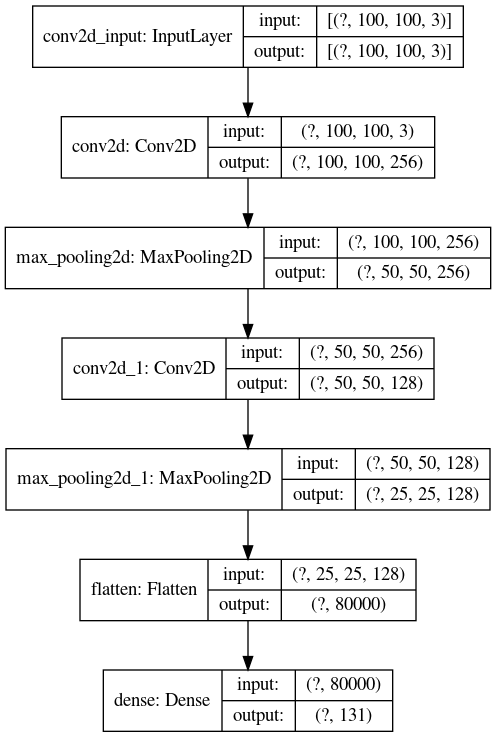

In [12]:
def cnn(image_size, num_classes):
    classifier = Sequential()
    classifier.add(Conv2D(256, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    return classifier

neuralnetwork_cnn = cnn(image_size, num_classes)
neuralnetwork_cnn.summary()
plot_model(neuralnetwork_cnn, show_shapes=True)

## Training and evaluating the model

In [13]:
history = neuralnetwork_cnn.fit(
    training_set, validation_data=validation_set,
    callbacks=[es, ckpt, rlp], epochs=n_epochs, 
)

Epoch 1/10
2116/2116 [==============================] - ETA: 0s - loss: 1.0267 - acc: 0.8105
Epoch 00001: loss improved from inf to 1.02671, saving model to model.h5
2116/2116 [==============================] - 396s 187ms/step - loss: 1.0267 - acc: 0.8105 - val_loss: 14.0638 - val_acc: 0.0812
Epoch 2/10
2115/2116 [============================>.] - ETA: 0s - loss: 0.3943 - acc: 0.9112
Epoch 00002: loss improved from 1.02671 to 0.39421, saving model to model.h5
2116/2116 [==============================] - 68s 32ms/step - loss: 0.3942 - acc: 0.9112 - val_loss: 13.8484 - val_acc: 0.1293
Epoch 3/10
2114/2116 [============================>.] - ETA: 0s - loss: 0.2470 - acc: 0.9449
Epoch 00003: loss improved from 0.39421 to 0.24690, saving model to model.h5
2116/2116 [==============================] - 67s 32ms/step - loss: 0.2469 - acc: 0.9449 - val_loss: 15.1323 - val_acc: 0.1169
Epoch 4/10
2115/2116 [============================>.] - ETA: 0s - loss: 0.1578 - acc: 0.9652
Epoch 00004: loss imp

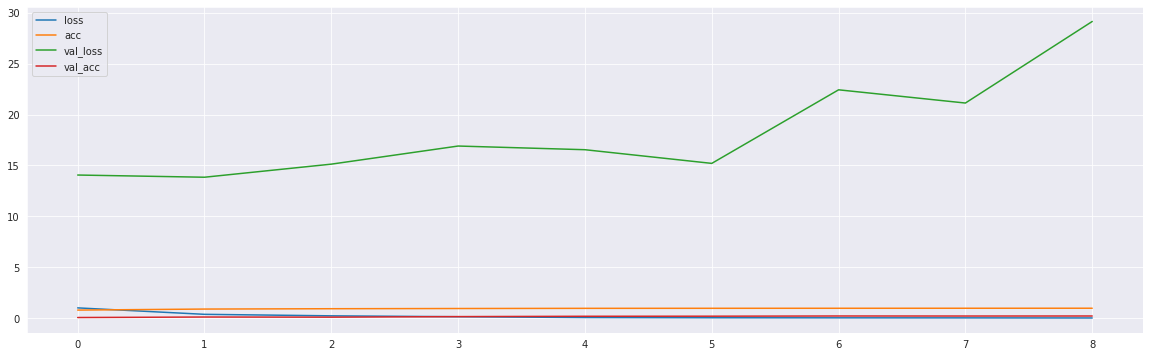

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, :-1].plot(ax=ax);

# Transfer Learning

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

There are two ways to customize a pretrained model

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset. You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.


## Commonly Used Models

Model |	Size | 	Parameters	| Depth
---|---|---|---
VGG16 |	528 MB | 138,357,544 | 23
VGG19 |	549 MB | 143,667,240 | 26
ResNet50 | 98 MB | 25,636,712 | -
InceptionV3 | 92 MB | 23,851,784 | 159
MobileNetV2 | 14 MB | 3,538,984 | 88

Complete List: [Keras Documentation](https://keras.io/api/applications/)

# Mobile Net V2 (Fine Tuning)

We will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large research dataset consisting of 1.4M images and 1000 classes. This base of knowledge will help us classify cats and dogs from our specific dataset.

The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

Apply a Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 131)               167811    
Total params: 2,425,795
Trainable params: 2,391,683
Non-trainable params: 34,112
_________________________________________________________________


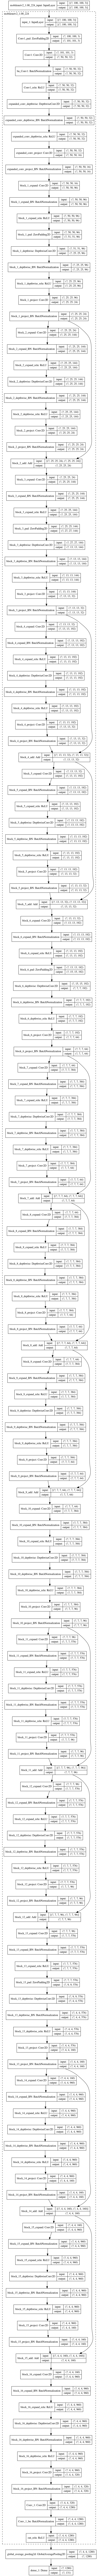

In [15]:
base_model = applications.MobileNetV2(input_shape=image_size, include_top=False, weights='imagenet')
base_model.trainable = True # True => Fine Tuning False=> Feature Extraction
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes, activation='softmax')

neuralnetwork_mobilenet = Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

neuralnetwork_mobilenet.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc']
)
neuralnetwork_mobilenet.summary()
plot_model(neuralnetwork_mobilenet, show_shapes=True, expand_nested=True)

In [16]:
history = neuralnetwork_mobilenet.fit(
    training_set, validation_data=validation_set,
    callbacks=[es, ckpt, rlp], epochs=n_epochs, 
)

Epoch 1/10
2116/2116 [==============================] - ETA: 0s - loss: 2.6735 - acc: 0.4601
Epoch 00001: loss did not improve from 0.03653
2116/2116 [==============================] - 107s 51ms/step - loss: 2.6735 - acc: 0.4601 - val_loss: 16.1772 - val_acc: 0.0100
Epoch 2/10
2115/2116 [============================>.] - ETA: 0s - loss: 1.3623 - acc: 0.6428
Epoch 00002: loss did not improve from 0.03653
2116/2116 [==============================] - 108s 51ms/step - loss: 1.3622 - acc: 0.6428 - val_loss: 38.1798 - val_acc: 0.0171
Epoch 3/10
2116/2116 [==============================] - ETA: 0s - loss: 1.1855 - acc: 0.6764
Epoch 00003: loss did not improve from 0.03653
2116/2116 [==============================] - 105s 49ms/step - loss: 1.1855 - acc: 0.6764 - val_loss: 33.0290 - val_acc: 0.0099
Epoch 4/10
2115/2116 [============================>.] - ETA: 0s - loss: 0.9726 - acc: 0.7447
Epoch 00004: loss did not improve from 0.03653
2116/2116 [==============================] - 106s 50ms/step

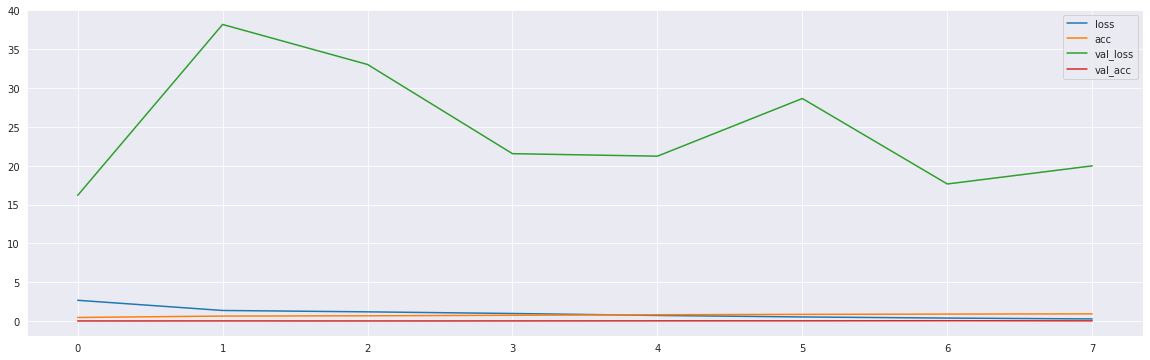

In [17]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, :-1].plot(ax=ax);

# Inception V3 (Feature Extraction)

Similar to Mobile Net V2, We will now create the base model from the Inception V3 model, but now we will use this model for feature extraction only

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 131)               268419    
Total params: 22,071,203
Trainable params: 268,419
Non-trainable params: 21,802,784
_________________________________________________________________


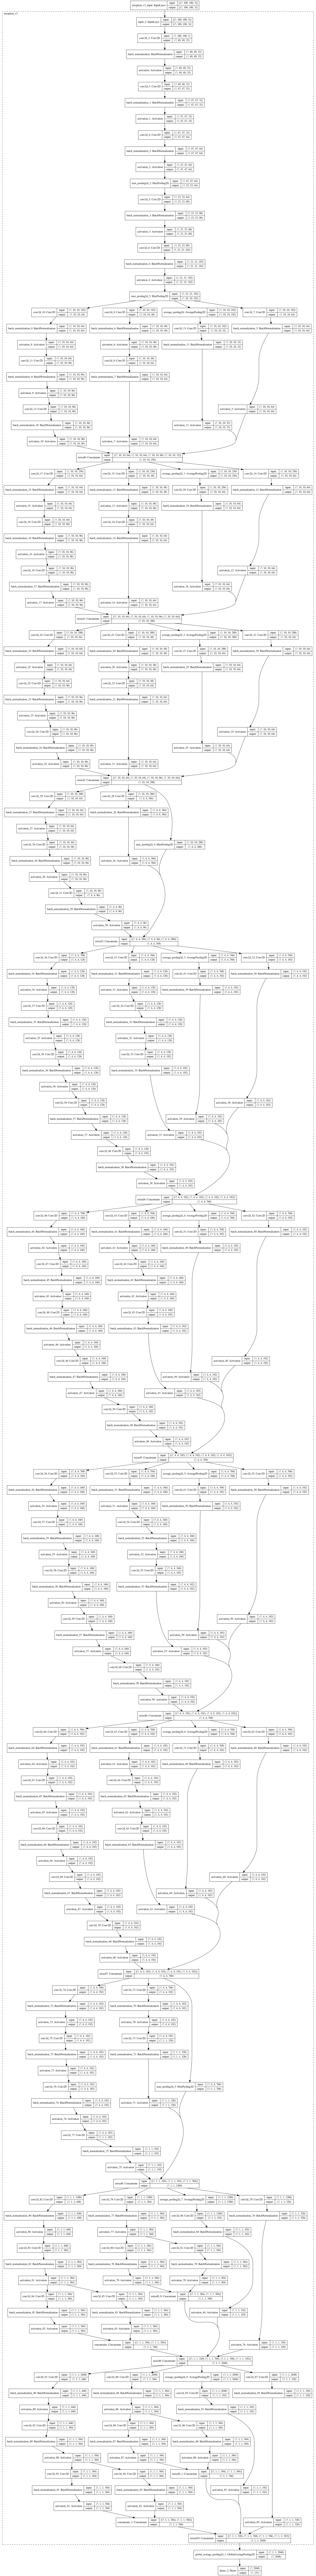

In [18]:
base_model = applications.InceptionV3(input_shape=image_size, include_top=False, weights='imagenet')
base_model.trainable = False # True => Fine Tuning False=> Feature Extraction
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes, activation='softmax')

neuralnetwork_inception = Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

neuralnetwork_inception.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc']
)
neuralnetwork_inception.summary()
plot_model(neuralnetwork_inception, show_shapes=True, expand_nested=True)

In [19]:
history = neuralnetwork_inception.fit(
    training_set, validation_data=validation_set,
    callbacks=[es, ckpt, rlp], epochs=n_epochs, 
)

Epoch 1/10
2116/2116 [==============================] - ETA: 0s - loss: 1.3613 - acc: 0.8184
Epoch 00001: loss did not improve from 0.03653
2116/2116 [==============================] - 70s 33ms/step - loss: 1.3613 - acc: 0.8184 - val_loss: 11.4271 - val_acc: 0.1302
Epoch 2/10
2115/2116 [============================>.] - ETA: 0s - loss: 0.5819 - acc: 0.9219
Epoch 00002: loss did not improve from 0.03653
2116/2116 [==============================] - 71s 33ms/step - loss: 0.5818 - acc: 0.9219 - val_loss: 7.2133 - val_acc: 0.2671
Epoch 3/10
2115/2116 [============================>.] - ETA: 0s - loss: 0.2222 - acc: 0.9591
Epoch 00003: loss did not improve from 0.03653
2116/2116 [==============================] - 71s 34ms/step - loss: 0.2221 - acc: 0.9591 - val_loss: 8.6463 - val_acc: 0.2865
Epoch 4/10
2114/2116 [============================>.] - ETA: 0s - loss: 0.2057 - acc: 0.9666
Epoch 00004: loss did not improve from 0.03653
2116/2116 [==============================] - 68s 32ms/step - los

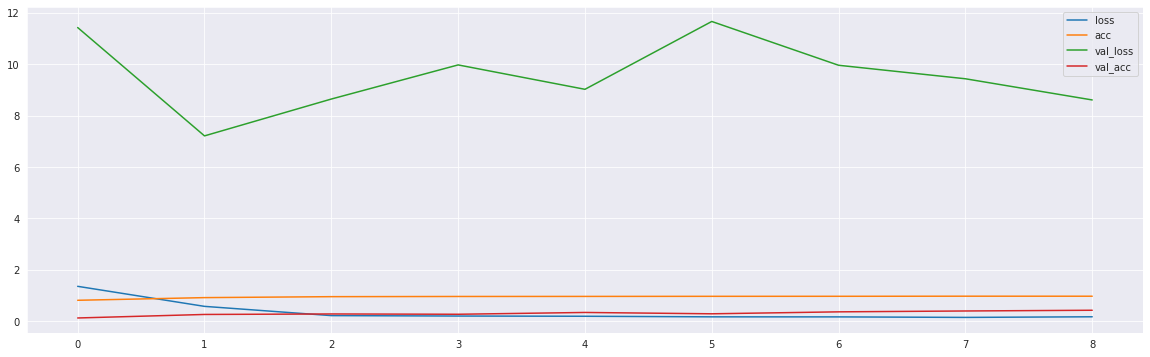

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, :-1].plot(ax=ax);